#### IMPORTACION ####

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# 1. Carga y exploración inicial de datos

In [98]:
print("="*50)
print("1. CARGANDO Y EXPLORANDO LOS DATOS")
print("="*50)
path = './titanic_train.csv'
df = pd.read_csv(path)

1. CARGANDO Y EXPLORANDO LOS DATOS


In [99]:
print("\nPrimeras filas del dataset:")
print(df.head())

print("\nInformación del dataset:")
print(df.info())


Primeras filas del dataset:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450

# 2. Preprocesamiento de datos

In [100]:
# Eliminación de columnas no relevantes
df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

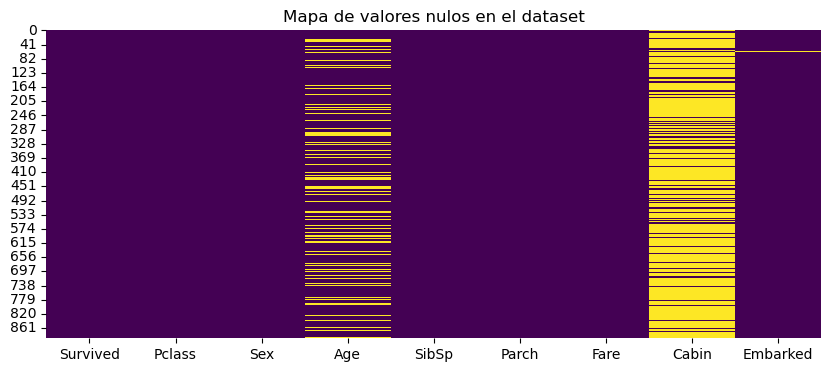

In [101]:
# Visualización de valores nulos
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Mapa de valores nulos en el dataset")
plt.show()

In [102]:
# Imputación de valores faltantes
imputer_mode = SimpleImputer(strategy='most_frequent')
df[['Embarked']] = imputer_mode.fit_transform(df[['Embarked']])

imputer_new_class = SimpleImputer(strategy='constant', fill_value='Unknown')
df[['Cabin']] = imputer_new_class.fit_transform(df[['Cabin']])

In [103]:
# Codificación de variables categóricas
encoder_sex = OneHotEncoder(drop='first', sparse_output=False)
df['Sex_male'] = encoder_sex.fit_transform(df[['Sex']])[:, 0]  # Asegura array 1D
df.drop(columns=['Sex'], inplace=True)

encoder_embarked = OrdinalEncoder(categories=[['S', 'C', 'Q']])
df[['Embarked']] = encoder_embarked.fit_transform(df[['Embarked']])

In [104]:
# Extracción y codificación de la cubierta (Deck)
df['Deck'] = df['Cabin'].str[0]
df.drop(columns=['Cabin'], inplace=True)

encoder_deck = OrdinalEncoder(categories=[["A", "B", "C", "D", "E", "F", "G", "T", "U"]])
df[["Deck"]] = encoder_deck.fit_transform(df[["Deck"]])

# 3. Predicción de edades faltantes

In [105]:
df_know_age = df[df['Age'].notnull()]
df_unknown_age = df[df['Age'].isnull()]

features_for_age = ['Fare', 'Parch', 'Pclass', 'SibSp', 'Deck']
X_train_age = df_know_age[features_for_age]
y_train_age = df_know_age['Age']
X_test_age = df_unknown_age[features_for_age]

model_age = RandomForestRegressor(random_state=42)
model_age.fit(X_train_age, y_train_age)
y_predict = model_age.predict(X_test_age)
df.loc[df['Age'].isnull(), 'Age'] = y_predict


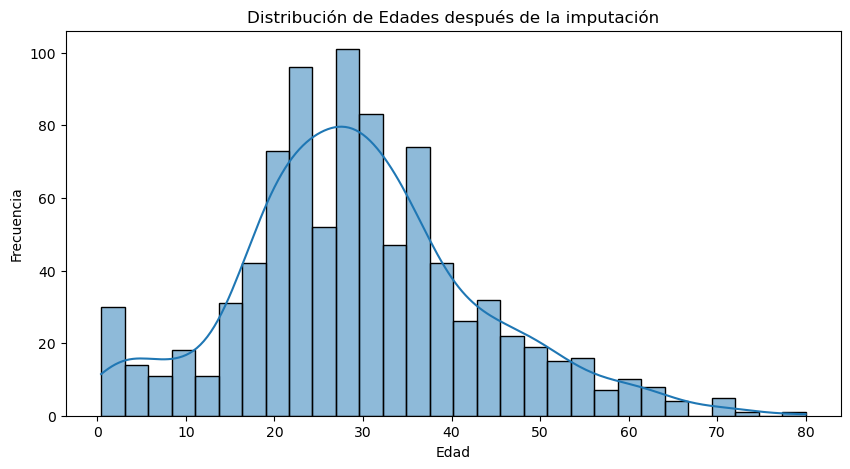

In [106]:
# Visualización distribución de edades
plt.figure(figsize=(10, 5))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title("Distribución de Edades después de la imputación")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

# 4. Estandarización de características

In [107]:
cols_selected = df.drop(columns='Survived').columns.tolist()
scaler = StandardScaler()
df[cols_selected] = scaler.fit_transform(df[cols_selected])

# 5. Selección de características y PCA

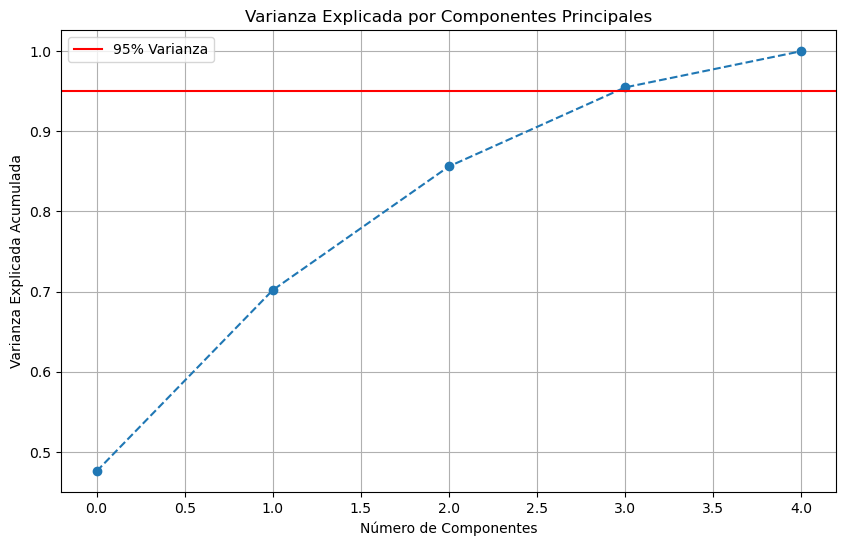

In [108]:
features = ['Sex_male', 'Age', 'Fare', 'Pclass', 'Deck']
X = df[features]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=42, shuffle=True
)

# Análisis PCA
pca_analysis = PCA().fit(X_train)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_analysis.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componentes Principales')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Varianza')
plt.legend(loc='best')
plt.show()

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 6. Entrenamiento y evaluación del modelo

In [109]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)

In [110]:
# Métricas de evaluación
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"\nAccuracy: {accuracy:.2f}%")


Accuracy: 87.71%


In [111]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=7)

In [112]:
# Antes de exportar, reentrena el scaler solo con las 5 features finales
final_features = ['Pclass', 'Age', 'Fare', 'Sex_male', 'Deck']
X_final = df[final_features]
final_scaler = StandardScaler().fit(X_final)

with open('titanic_model.pkl', 'wb') as f:
    pickle.dump({
        'model': model,
        'pca': pca,
        'scaler': final_scaler,  # Usar el scaler de solo 5 features
        'sex_encoder': encoder_sex,
        'deck_encoder': encoder_deck,
        'feature_names': final_features  # Asegurar nombres consistentes
    }, f)
print("Modelo exportado correctamente como 'titanic_model.pkl'")

Modelo exportado correctamente como 'titanic_model.pkl'
